## Import and configuration

In [117]:
import urllib3
import requests
import bs4
from selenium import webdriver
from requests_html import AsyncHTMLSession, HTMLSession
from pathlib import Path
import yfinance as yf
%run eurostat.py

mpl.rcParams["figure.figsize"] = 10,10
mpl.style.use("ggplot")

## Scraping eurostat

In [17]:
http = urllib3.PoolManager()
request = http.request("GET", "https://ec.europa.eu/eurostat/web/main/data/database")
page = bs4.BeautifulSoup(request.data.decode("utf8"), "html.parser")
page.find_all(src = "/eurostat/o/NavTree-portlet-prod/images/connector-open.gif")
# explore selenium and other solutions to use so js can render

[]

In [19]:
browser = webdriver.Firefox()
browser.get("https://ec.europa.eu/eurostat/web/main/data/database")
browser.quit()
# Too possible but need to collapse everything manually with webdriver, takes quite a long time
None

In [20]:
# asession = AsyncHTMLSession()
session = HTMLSession()
r = session.get("https://ec.europa.eu/eurostat/web/main/data/database")
r.html.absolute_links
# r.html.render()
# not working in ipython notebooks, run in regular .py - problems with asyncio
None

In [26]:
### BEST WAY: there is a bulk download page on eurostat, use requests-html to get page
session = HTMLSession()
r = session.get("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?dir=data&sort=1&sort=2&start=all")
links = list(filter(lambda x: x.endswith(".tsv.gz") and x.__contains__("&downfile"), r.html.absolute_links)) # uses bs4 internally to parse html
names = list(map(process_link, links))
# link_mapping = pd.DataFrame(data = {"short_name": names, "urls": links})
link_mapping = pd.DataFrame(index = names, columns = ["links"], data = links)
len(link_mapping)

6505

### Loading datasets

In [45]:
kbc = yf.Ticker("KBC.BR")
kbc_close = kbc.history(period = "max").Close

In [34]:
# link_mapping[link_mapping.index.str.contains("euryld")] # get euryld datasets
interestrates_euryield_daily = pd.read_csv(link_mapping.at["irt_euryld_d.tsv.gz", "links"], delimiter = "\t")
interestrates_euryield_daily.set_index(interestrates_euryield_daily.columns[0], inplace = True)
interestrates_euryield_daily.columns = pd.to_datetime(list(map(process_datestring, interestrates_euryield_daily.columns)))

In [112]:
sorting_bonds = pd.DataFrame(index = interestrates_euryield_daily.index, columns = ["yld_curv", "maturity", "bonds", "geo\\time"])
sorting_bonds["yld_curv"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[0]).array
sorting_bonds["maturity"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[1]).array
sorting_bonds["bonds"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[2]).array
sorting_bonds["geo\\time"] = pd.Series(sorting_bonds.index).apply(lambda x: x.split(",")[3]).array
total_options = 1
for x in sorting_bonds.columns:
    sorting_bonds[x] = sorting_bonds[x].astype("category")
    options = list(sorting_bonds[x].cat.categories)
    print("{} options for {}:".format(len(options), x))
    print("\t", end = "")
    for i, e in enumerate(options):
        if i == len(options) - 1:
            print(e)
        else:
            print(f"{e} - ", end = "")
    total_options *= len(options)
print("Total options = {}".format(total_options))

3 options for yld_curv:
	INS_FWD - PAR - SPOT_RT
30 options for maturity:
	Y1 - Y10 - Y11 - Y12 - Y13 - Y14 - Y15 - Y16 - Y17 - Y18 - Y19 - Y2 - Y20 - Y21 - Y22 - Y23 - Y24 - Y25 - Y26 - Y27 - Y28 - Y29 - Y3 - Y30 - Y4 - Y5 - Y6 - Y7 - Y8 - Y9
2 options for bonds:
	CGB_EA - CGB_EA_AAA
1 options for geo\time:
	EA
Total options = 180


### Plotting and processing

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

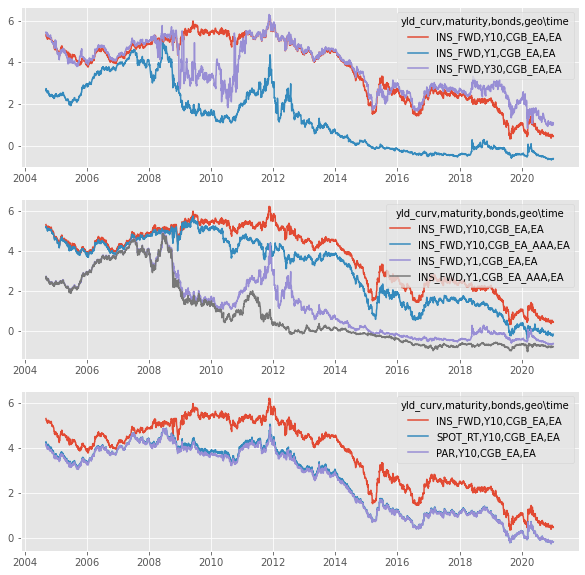

In [119]:
plt.clf()
fig, axs = plt.subplots(3, 1)
selected1 = [
    "INS_FWD,Y10,CGB_EA,EA", # forward regular long term (10 years)
    "INS_FWD,Y1,CGB_EA,EA", # forward regular short term (1 year)
    "INS_FWD,Y30,CGB_EA,EA" # forward regular extra long term (10 years)
]
selected2 = [
    "INS_FWD,Y10,CGB_EA,EA", 
    "INS_FWD,Y10,CGB_EA_AAA,EA", # AAA credit rating? --> safer so less interest
    "INS_FWD,Y1,CGB_EA,EA", 
    "INS_FWD,Y1,CGB_EA_AAA,EA"
]
selected3 = [
    "INS_FWD,Y10,CGB_EA,EA", 
    "SPOT_RT,Y10,CGB_EA,EA", 
    "PAR,Y10,CGB_EA,EA"
]
sns.lineplot(data = interestrates_euryield_daily.T[selected1], ax = axs[0], dashes = None)
sns.lineplot(data = interestrates_euryield_daily.T[selected2], ax = axs[1], dashes = None)
sns.lineplot(data = interestrates_euryield_daily.T[selected3], ax = axs[2], dashes = None)

In [140]:
irt = interestrates_euryield_daily.T[["INS_FWD,Y10,CGB_EA,EA", "INS_FWD,Y1,CGB_EA,EA", "INS_FWD,Y30,CGB_EA,EA"]]
full = irt.merge(kbc_close, left_index = True, right_index = True).rename({"Close": "kbc_close"}, axis = 1)
full.sort_index(inplace = True)
full_perc_start = full.copy()
for k, v in full_perc_start.iteritems():
    full_perc_start[k] = v / v[0] * 100
full_perc_start

,"INS_FWD,Y10,CGB_EA,EA","INS_FWD,Y1,CGB_EA,EA","INS_FWD,Y30,CGB_EA,EA",kbc_close
2004-09-06,100.000000,100.000000,100.000000,100.000000
2004-09-07,99.436090,101.492537,100.000000,99.605148
2004-09-08,99.436090,102.611940,99.816514,100.493561
2004-09-09,98.684211,100.000000,99.266055,100.493561
2004-09-10,98.496241,97.761194,98.715596,100.000000
...,...,...,...,...
2020-12-30,9.210526,-23.134328,18.165138,182.590646
2021-01-04,9.210526,-23.880597,20.550459,180.654839
2021-01-05,8.646617,-22.761194,18.715596,174.660064
2021-01-06,8.834586,-22.014925,20.366972,184.151784


<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

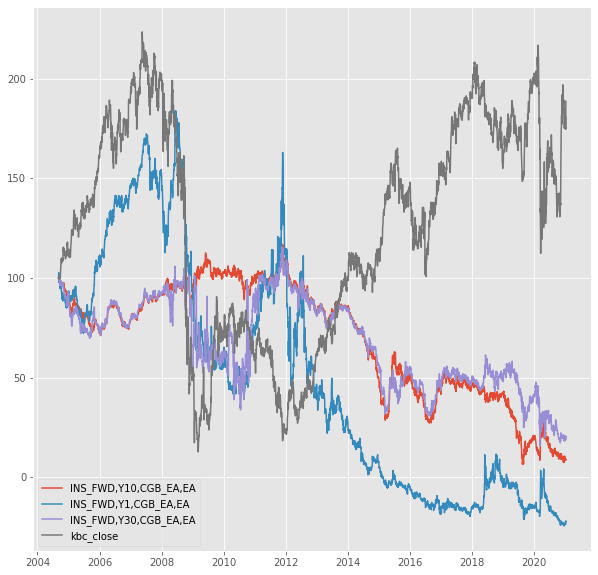

In [143]:
plt.clf()
fig, ax = plt.subplots(1, 1)
sns.lineplot(data = full_perc_start, ax = ax, dashes = None)

In [152]:
full_perc_start.corr(method = "spearman")

,"INS_FWD,Y10,CGB_EA,EA","INS_FWD,Y1,CGB_EA,EA","INS_FWD,Y30,CGB_EA,EA",kbc_close
"INS_FWD,Y10,CGB_EA,EA",1.000000,0.744316,0.762617,-0.580924
"INS_FWD,Y1,CGB_EA,EA",0.744316,1.000000,0.834248,-0.161440
"INS_FWD,Y30,CGB_EA,EA",0.762617,0.834248,1.000000,-0.337141
kbc_close,-0.580924,-0.161440,-0.337141,1.000000


In [148]:
eu27_trade = pd.read_csv(link_mapping.at["ei_eteu27_2020_m.tsv.gz", "links"], delimiter = "\t", low_memory = True)

In [149]:
eu27_trade

,"stk_flow,unit,partner,indic,geo\time",2020M10,2020M09,2020M08,2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,...,1999M10,1999M09,1999M08,1999M07,1999M06,1999M05,1999M04,1999M03,1999M02,1999M01
0,"BAL_RT,IVOL-NSA,EA19,ET-CAP,AT",:,99.6,98.9,93.7,95.5,95.3,89.3,96.1,96.9,...,:,:,:,:,:,:,:,:,:,:
1,"BAL_RT,IVOL-NSA,EA19,ET-CAP,BE",:,98.4,94.3,85.4,82.4,92.0,85.1,93.0,79.2,...,:,:,:,:,:,:,:,:,:,:
2,"BAL_RT,IVOL-NSA,EA19,ET-CAP,BG",:,207.4,190.9,168.2,187.6,176.1,222.8,200.8,200.6,...,:,:,:,:,:,:,:,:,:,:
3,"BAL_RT,IVOL-NSA,EA19,ET-CAP,CY",:,9.4,23.7,5.9,216.2,15.4,15.4,12.4,64.5,...,:,:,:,:,:,:,:,:,:,:
4,"BAL_RT,IVOL-NSA,EA19,ET-CAP,CZ",: n,125.8,122.9,123.5,133.1,129.8,145.2,108.3,118.1,...,:,:,:,:,:,:,:,:,:,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22135,"IMP,RT12-IVU-NSA,WORLD,ET-T,PT",:,-1.9,-2.3,-2.5,-2.3,-3.2,-6.1,-0.6,1.8,...,:,:,:,:,:,:,:,:,:,:
22136,"IMP,RT12-IVU-NSA,WORLD,ET-T,RO",:,-2.6,-2.0,-2.1,-2.9,-3.2,-2.3,-1.2,-0.3,...,:,:,:,:,:,:,:,:,:,:
22137,"IMP,RT12-IVU-NSA,WORLD,ET-T,SE",:,-4.5,0.1,-1.8,-2.3,-3.8,-7.3,-5.6,0.6,...,:,:,:,:,:,:,:,:,:,:
22138,"IMP,RT12-IVU-NSA,WORLD,ET-T,SI",:,-3.0,-8.1,-7.1,-7.7,-6.8,-6.6,-1.0,0.7,...,:,:,:,:,:,:,:,:,:,:
